<a href="https://colab.research.google.com/github/GundetiManoj99/Molecule-generation/blob/main/markov_synthesis_aromatic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Setup and Import Libraries for Molecular Generation


In [ ]:
!pip install optuna rdkit_pypi deepchem transformers matplotlib tqdm hmmlearn xgboost

In [ ]:
import os
from typing import List
import random
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import rdkit.Chem.Descriptors
from hmmlearn.hmm import MultinomialHMM
from hmmlearn.hmm import CategoricalHMM
import xgboost

import rdkit
rdkit.RDLogger.DisableLog('rdApp.*')
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem import Lipinski,Descriptors
import functools

In [ ]:
# Create a new directory named 'new_directory'
!mkdir -p datasets

# Move the file 'file-cFr6VmYXiISRDMrj92GFH55R' into 'new_directory'


In [ ]:
#!mv /content/dataset2.csv datasets/

In [ ]:
!mv /content/Woody.csv datasets/

In [ ]:
!mv /content/Citrus.csv datasets/

In [ ]:
!mv /content/Fatty.csv datasets/

In [ ]:
!mv /content/Fresh.csv datasets/

In [ ]:
!mv /content/Fruity.csv datasets/

In [ ]:
!mv /content/Ripe.csv datasets/

In [ ]:
!mv /content/Green.csv datasets/

In [ ]:
!mv /content/Sweet.csv datasets/

In [ ]:
!mv /content/Spicy.csv datasets/

In [ ]:
!mv /content/flavordb_data.csv datasets/

### Understanding Hidden States in a Hidden Markov Model (HMM)

In the context of a Hidden Markov Model (HMM), "hidden states" represent the underlying states that are not directly observable but influence the observed sequence. These hidden states help model the dependencies and transitions in the sequence of observations.

### Example with SMILES Strings

*SMILES Strings*:
- "CCOCC"
- "CCNCC"
- "COCCO"
- "NCCCN"

*Alphabet*:
- {'C', 'O', 'N'}

*Hidden States*:
- *State1*
- *State2*
- *State3*

### Role of Hidden States

1. *Representation of Underlying Patterns*: Hidden states in an HMM capture the underlying patterns or structures within the sequences of symbols. In the context of SMILES strings, these states could represent different types of molecular environments or bonding patterns.

### Generating New Molecules Using HMM

To generate new molecules using a Hidden Markov Model (HMM), we can leverage the learned transition and emission probabilities. This process involves:

1. *Starting from an Initial State*: Use the initial state probabilities to choose a starting state.
2. *Generating Symbols*: Based on the current state, use the emission probabilities to generate a symbol.
3. *Transitioning to Next State*: Use the transition probabilities to determine the next state.
4. *Repeating the Process*: Continue generating symbols and transitioning states until a termination condition is met (e.g., a specific length of the sequence).

### Step-by-Step Process

Let's assume we have the following transition and emission probabilities from our previous example:

*Transition Probabilities*:

| From \ To | State1 | State2 | State3 |
|-----------|--------|--------|--------|
| State1    | 0.4    | 0.3    | 0.3    |
| State2    | 0.5    | 0.333  | 0.167  |
| State3    | 0.5    | 0.25   | 0.25   |

*Emission Probabilities*:

| State  | 'C'  | 'O'  | 'N'  |
|--------|------|------|------|
| State1 | 0.6  | 0.2  | 0.2  |
| State2 | 0.667| 0.167| 0.167|
| State3 | 0.5  | 0.333| 0.167|

### Example: Generating a New Molecule

#### 1. *Initialization*

Start with equal probability for each state:
- P(State1) = 1/3
- P(State2) = 1/3
- P(State3) = 1/3

Randomly choose an initial state based on these probabilities. Assume we start with State2.

#### 2. *Generating the First Symbol*

From State2, use the emission probabilities to generate a symbol:
- P('C'|State2) = 0.667
- P('O'|State2) = 0.167
- P('N'|State2) = 0.167

Assume we randomly generate 'C' (based on the highest probability).

#### 3. *Transitioning to the Next State*

From State2, use the transition probabilities to determine the next state:
- P(State1|State2) = 0.5
- P(State2|State2) = 0.333
- P(State3|State2) = 0.167

Assume we randomly transition to State1.

#### 4. *Repeating the Process*

Repeat the process to generate the next symbols and states. Here's a possible sequence of steps:

*Current State*: State1
- Generate Symbol: From State1, highest emission probability is for 'C'.
- Transition: From State1, transition to State3.

*Current State*: State3
- Generate Symbol: From State3, possible symbols are 'C', 'O', 'N'.
- Assume we generate 'O'.
- Transition: From State3, transition to State1.

*Current State*: State1
- Generate Symbol: From State1, highest emission probability is for 'C'.
- Transition: From State1, transition to State2.

*Current State*: State2
- Generate Symbol: From State2, highest emission probability is for 'C'.
- Transition: From State2, transition to State3.

*Current State*: State3
- Generate Symbol: From State3, possible symbols are 'C', 'O', 'N'.
- Assume we generate 'N'.
- Transition: From State3, transition to State1.

Repeat this process to generate a sequence of a desired length, resulting in a new SMILES string.

### Example Generated Sequence

Assume the following sequence of states and symbols is generated:
1. Start at State2, generate 'C'
2. Transition to State1, generate 'C'
3. Transition to State3, generate 'O'
4. Transition to State1, generate 'C'
5. Transition to State2, generate 'C'
6. Transition to State3, generate 'N'

The generated SMILES string could be: *"CCOCCN"*

### Conclusion

By using the transition and emission probabilities learned from training the HMM, we can generate new sequences of symbols that represent new SMILES strings. This process leverages the probabilistic nature of the HMM to create novel combinations, potentially leading to new molecular structures not present in the original dataset.


In [ ]:
dataset_path = '/content/datasets'
files = [i for i in os.listdir(dataset_path) if i.endswith('csv')]

all_smiles = set()

for file in files:
    df = pd.read_csv(os.path.join(dataset_path, file))
    all_smiles.update(df.smiles.dropna())

all_smiles = set(smile for smile in all_smiles)
print(f"total of {len(all_smiles)} smiles")
print("Sample smiles:")
for count, smile in enumerate(all_smiles):
    print(smile)
    if count > 10:
        break


**Convert Strings to Tokens & Preprocess using DeepChem:**
This script is designed to patch an issue in the DeepChem library and implement a custom class for encoding and decoding SMILES strings, which are used to represent chemical structures. The code follows these steps:

Patch DeepChem to fix a known issue.
Import necessary modules and libraries.
Define a SmilesEncoder class to handle SMILES string tokenization and detokenization.
Encode a list of SMILES strings and shuffle the encoded data.


In [ ]:
# Need to patch deepchem first per https://github.com/deepchem/deepchem/issues/2519
import re, importlib
deepchem_root_path = importlib.util.find_spec('deepchem').origin
smiles_tokenizer_path = os.path.join(os.path.dirname(deepchem_root_path), "feat", "smiles_tokenizer.py")

with open(smiles_tokenizer_path, "r") as inp:
    file_contents = inp.read()

with open(smiles_tokenizer_path, "w") as outp:
    for line in file_contents.split("\n"):
        outp.write(re.sub("max_len\(\s\)", "model_max_length", line) + "\n")

In [ ]:
from deepchem.feat.smiles_tokenizer import SmilesTokenizer

In [ ]:
class SmilesEncoder():
    def __init__(self):
        # Download Deepchem's vocabulary file if we don't already have it
        vocab_url = "https://raw.githubusercontent.com/deepchem/deepchem/master/deepchem/feat/tests/data/vocab.txt"
        self.vocab_path = "/content/vocab.txt"
        if not os.path.exists(self.vocab_path):
            with open(vocab_url, "wb") as outp:
                download = urllib.request.urlopen(vocab_url)
                outp.write(download.read())
                # Also, make sure colons are in our vocabulary
                outp.write(b"\n:")

        self.tokenizer = SmilesTokenizer(self.vocab_path)
        self.inversion_dict = {value: key for key, value in self.tokenizer.vocab.items()}

        self.ignored_range = list(range(self.tokenizer.vocab['[PAD]'], self.tokenizer.vocab['[MASK]']))

    def transform(self, X: str) -> List[int]:
        # Don't care about the start/end (X)
        tokenized = self.tokenizer.encode(X)
        return tokenized

    def inverse_transform(self, X: List[int]) -> str:
        sep = self.tokenizer.vocab['[SEP]']
        if sep in X:
            end_index = np.random.choice(np.where(X == sep)[0])
            if end_index <= 1:
                end_index = -1
        else:
          end_index = -1
        result = "".join(self.inversion_dict[i] for i in X[1:end_index] if i not in self.ignored_range)
        return result
enc = SmilesEncoder()

In [ ]:
encoded =list(map(enc.transform,all_smiles))
np.random.shuffle(encoded)

**Optimizing Hidden Markov Model (HMM) States**:

This script defines a function to optimize the number of states in a Hidden Markov Model (HMM) using the CategoricalHMM from the hmmlearn library. The goal is to find the optimal number of states that provide the best fit for the given data.

In [ ]:
def objective(n_states:int)->int:
  n_subsamples=16
  subsample_size =128
  total=0
  for n in tqdm.trange(n_subsamples):
    model= CategoricalHMM(n_states, verbose=False, n_iter=64)
    x=np.concatenate([random.choice(encoded) for _ in range(subsample_size)]).reshape(-1,1)
    model.fit(x)
    total+=model.score(x)
  mean=total/n_subsamples
  return mean
vals=[]
n_max = 6
for n in range(1, n_max+1):
  print(f"{n} states",flush=True)
  vals.append(objective(n))

1 states


100%|██████████| 16/16 [00:00<00:00, 256.50it/s]

2 states



100%|██████████| 16/16 [00:02<00:00,  6.80it/s]

3 states



100%|██████████| 16/16 [00:05<00:00,  3.19it/s]

4 states



100%|██████████| 16/16 [00:08<00:00,  1.86it/s]

5 states



100%|██████████| 16/16 [00:22<00:00,  1.43s/it]

6 states



100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


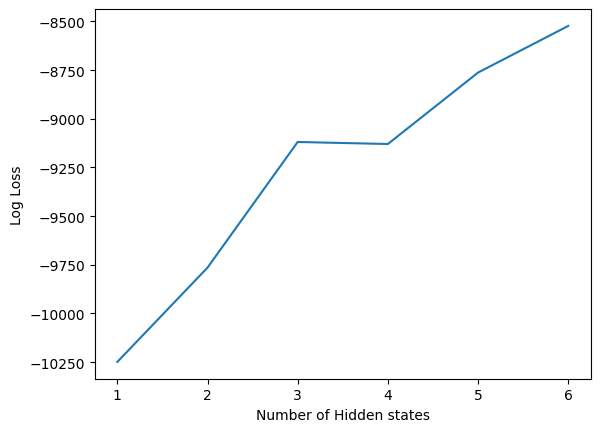

In [ ]:
plt.plot(list(range(1,len(vals)+1)),vals)
plt.xlabel("Number of Hidden states")
plt.ylabel("Log Loss")
plt.show()
plt.close()

In [ ]:
best_n, best_loss =max(enumerate(vals,1), key=lambda i: i[0])
print(f"Training with {best_n} hidden states")
model = CategoricalHMM(best_n, verbose=True, n_iter=1024)
model.fit(np.concatenate(encoded).reshape(-1, 1))


Training with 6 hidden states


         1 -865691.42903338             +nan
         2 -320832.96008896 +544858.46894442
         3 -313663.60922809   +7169.35086087
         4 -305488.43140071   +8175.17782739
         5 -299452.24826808   +6036.18313263
         6 -295568.46379301   +3883.78447507
         7 -292337.54044350   +3230.92334951
         8 -289387.21817152   +2950.32227198
         9 -286701.94527503   +2685.27289648
        10 -284313.32475676   +2388.62051828
        11 -282180.12507551   +2133.19968125
        12 -280266.67469564   +1913.45037986
        13 -278671.72508638   +1594.94960927
        14 -277461.65319703   +1210.07188935
        15 -276508.88050442    +952.77269262
        16 -275616.88540379    +891.99510063
        17 -274696.69470253    +920.19070126
        18 -273781.43853926    +915.25616327
        19 -273016.85205138    +764.58648788
        20 -272504.12419260    +512.72785878
        21 -272186.91180952    +317.21238308
        22 -271982.87636013    +204.03544939
        23

CategoricalHMM(n_components=6, n_features=393, n_iter=1024,
               random_state=RandomState(MT19937) at 0x7F1374FF9E40,
               verbose=True)

In [ ]:
# import pickle
# with open("/content/markov1.pkl","wb") as outp:
#   pickle.dump(model,outp)

**Generating Molecules with Specific Heavy Atom Counts**:

This script defines a function to generate chemical molecules with a specified range of heavy atoms (non-hydrogen atoms) using a Hidden Markov Model (HMM) and RDKit for molecular manipulation. The function aims to produce a given number of valid molecules within the defined range of heavy atoms.

In [ ]:
def generate_molecules(min_heavy_atoms: int, max_heavy_atoms: int, num_mols: int, verbose: bool = True) -> List[rdkit.Chem.Mol]:
    pred_mols = []
    while len(pred_mols) < num_mols:
        sample, _ = model.sample(max_heavy_atoms)
        sample = sample.T[0]
        pred = enc.inverse_transform(sample)
        print(pred)
        try:
            mol = Chem.MolFromSmiles(pred)
        except:
            mol = None
        if mol and mol.GetNumAtoms() >= min_heavy_atoms:
            pred_mols.append(mol)
            if verbose:
                print(f"Found {len(pred_mols)} molecules. New molecule has weight {np.round(Chem.Descriptors.MolWt(mol), 3)} amu")

    return pred_mols



In [ ]:
# def load_model(file_path: str):
#     with open(file_path, "rb") as inp:
#         return pickle.load(inp)

# # Load the model
# pipeline = load_model("markov1.pkl")

 **Filter Aromatic Molecules using RDKit:**
  - Identify and filter out aromatic molecules from the generated set using RDKit's aromaticity detection.

In [ ]:
from rdkit.Chem import Lipinski, Descriptors
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem import Lipinski,Descriptors
import functools
def is_aromatic(smiles):
    # Convert the SMILES string to an RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)

    if molecule is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")

    # Check if the molecule is aromatic
    aromatic_atoms = [atom.GetIsAromatic() for atom in molecule.GetAtoms()]

    # If any atom in the molecule is aromatic, we consider the molecule aromatic
    return any(aromatic_atoms)


In [ ]:
aromatic_candidates = []
n_desired_candidates = 3

while len(aromatic_candidates) < n_desired_candidates:
    generated_molecules = generate_molecules(min_heavy_atoms=5, max_heavy_atoms=30, num_mols=10, verbose=False)
    smiles_list = [Chem.MolToSmiles(mol) for mol in generated_molecules if mol is not None]  # Ensure valid SMILES
    aromatic_candidates += list(filter(is_aromatic, smiles_list))
    print(f"Found {len(aromatic_candidates)} aromatic molecules")


Streaming output truncated to the last 5000 lines.
OC(ccC(O)OC()cNCCC(=
O1=)cCC((
cOc(c1C1CC(C=c(OC()=O)=O)c1C
CCC1OC1OO)C1
C(
c(OCNC1C1C1C(BrC1Cl
[Na+][O-]C.=OO)C1cC(Oc(=
)C((OO)C1C(c2)C(O)=O)C(cS
c1OC(OC=cC(O)C(OO=C(C)C1CC1
cC((O)C(CC1c2
C(O)c(OO)
(C)c(=O)cc1O)=OCC1=C1(
S1OOCc.OO)cC(CC2C)CnC(=
C(Nc1=
cCC(=O)=O)c(=C(=
CCC(NO)OC(S1cC(CO)CNC(=CC5O)
c.C)cCC1=O)CCc1CC2)CCC7CCC5=
cO[Na+](CC(F(CC((
cCCccC1c6=O)OOCcCC11O)CcCOC
C(cC1NC(C(OO)CP25CcCCC(=O)O
=CC2CCCcC(Oc(n(CcC1=Br)C1=S
[C@@H]1
C1CC(=O)CO4c[O-]CNC(CCCC(CCC(C
C1/CCN1=
C(=C1COOO)
C3
CC(C1C1=Cc2=O=O6)C()cC42)C2
1CC(C1CCNBr)c2O)[C@H]1
C1CN1=CC)C()c()CCc(Cc1
O([O-])=O)=Cc(C)C(
C(cC1=O)ccCCC(Cc1Oc1OCC(C.O
()(
O
C2=
O)[Ca+2]2=O=C)=N
C1NOc(Oc2OO)=OO)CC(CC.
)c(cCOCCNC(Cl)=[O-]).CC(4[C@@H]4CCc
CCC(OCC1OO(OC1OC1C(cCOC1C(C(
N1NC(cC(Br)/Cc(OCCc(2C(NCC=
C(cC(O)(
OC((O=
cC(NC(C)(O)2O)CO)OC2OC1OC(C(
C2C3(C)CN)C1C1CCCc(NCCc(=O
CCC=)c(OcCCcCC(=
CCCCCC(=O)c.OCC1OC(O)OC1c1OC
OOO)1=1O)Nc(=N)OC)C(NC(=C1OC
)C2CCC=C)cCC(CN1OO)OO)COCc
cC()CCC(CC1SO)=c(CC

In [ ]:
print(aromatic_candidates)

['CCc1c(C)c1=O', 'Cc1[nH]cc(O)ooc1C', 'COC(C)=CNc1[nH]c(OO)c(O)c1Cl']


**Visualize Molecules:**
   - Visualize the filtered aromatic molecules to analyze the generated structures

In [ ]:
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
def plot_smiles(smiles):
    # Convert the SMILES string to an RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)

    if molecule is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")

    # Generate a 2D depiction of the molecule
    molecule_image = Draw.MolToImage(molecule)

    # Plot the image using matplotlib
    plt.imshow(molecule_image)
    plt.axis('off')  # Turn off axis
    plt.show()

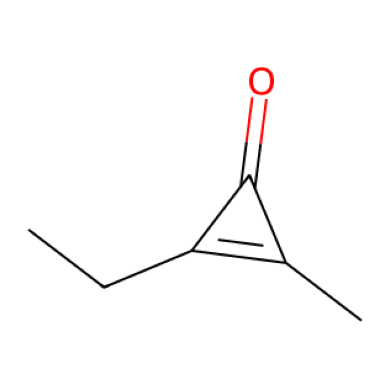

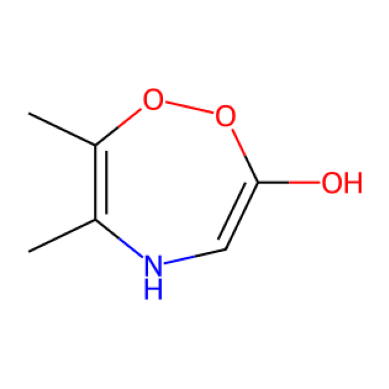

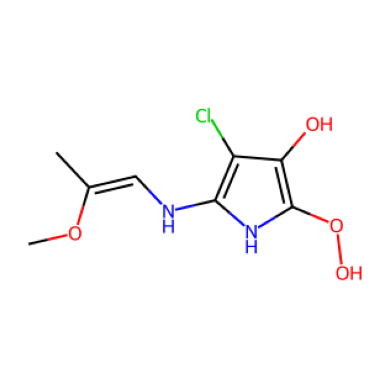

In [ ]:

for mol in aromatic_candidates:
    plot_smiles(mol)

ALL GENERATED MOLECULES CODE

In [ ]:
gen=generate_molecules(min_heavy_atoms=5, max_heavy_atoms=30, num_mols=40, verbose=False)

Streaming output truncated to the last 5000 lines.
(O)C(OC(O)1=2((CO)C(cCC1=3
Oc(=O)=Cl)CccCC=c1O)OC(CC=O
OC)CC)ccc=O)([O-])=CCc1C5O)C(=C
CC.O)c1CccnC(OO)C(CC((O)2C(N
C2C)OC)CcC(C1C)NN(cC(=CCcCCN
cc(3)CCc()CC.=
=O)=S(O=C(C()OOC=OCC(=C1Cc
C4O)cOCOC(CO)CC(C1CcC1c[Na+]1OCc
CS1=C(=CC(CC2=O)cccnOCCcCC1
=OcC1C(OO(COC=C(=
1OC()CC(2OCcCCCCCOC(cCc==O
S1C(C1cC(C)CcCC(C[Na+]Ccc2Oc(CO
CCcccCC(=O(C)CNccCc[Na+]2=S)=c1
N()=O)C(O)CC1OC(CCC(Nc1O)=C1
C(CCc1O)CCC1OC1OC()=O)C=c1=
C1OO)C(O)CC(O
C(OC1C(OCC()COCC(OcCcc1OcC
C1OC=
C1=
=O)=
=O)OCNCC1O[Na+]c(cCC(=OC(=N)=C
cC1(O)C(Cc(=C((C)CCC1=
C4(N
C1c(=C)c(=O)c2=O)CC(cC(cCCC1
(=O)=OC1=N[C@@H]OC1CCc(CO)(ClON1C1
cC1CC2COc(cOc1c1=O=
O)=C(S(OC(=O)=O)C(cC(C[Na+]1c1
cCOPOC(C(OC1(N
O)O)C1N
=OCC2=C)CC2CO)CC)CC1CC1OO)=C
C(c1COC(CC2CC(=O)C1
C1N
O)OS1O)OC(CO)=C(=O)CC1C)=OC
C(ccCc(OO)C(O)=O)c()#)
[Na+]1O)(=OCNC((O
=O)C(=c(OCOcCc()CCO3[C@@]C2
(CCC(O)C1FC1(OO)OO)CC(=C)OC
=O)Oc1CCCcCS2CCOcCC#([O-]CCOC
C1C(C(C1=C[O-])C(Nc(O)C(C(C(CO)
COC4=CCO=Cc2O)C3C
C(=OC)Cc(O)C2cC2c=C2OCC(

Visualize Molecules:
   - Visualize All generated molecules to analyze the generated structures with IUPAC names and Molecular formula

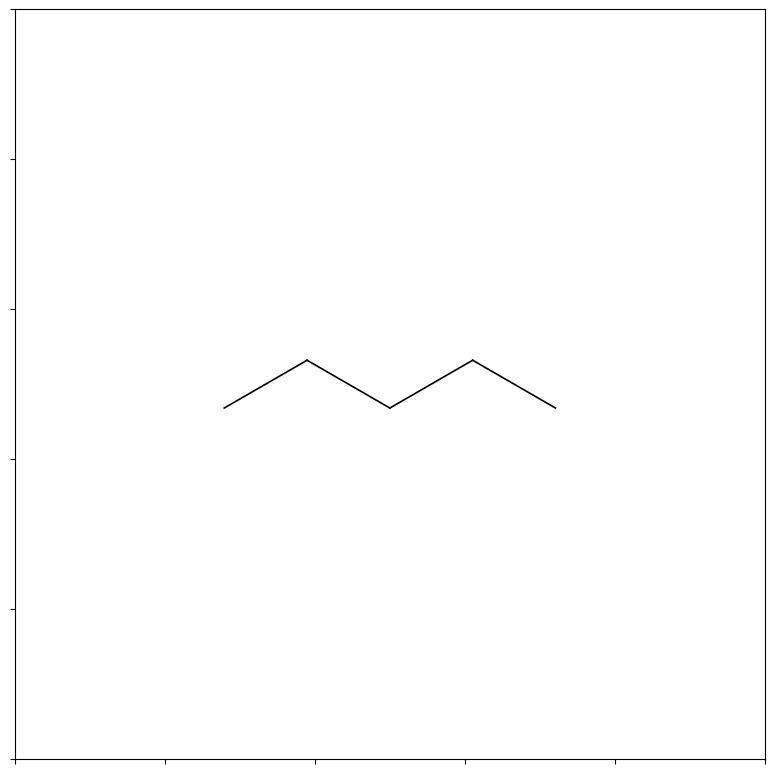

SMILES: CCCCC, Molecular Formula: C5H12, IUPAC Name: pentane


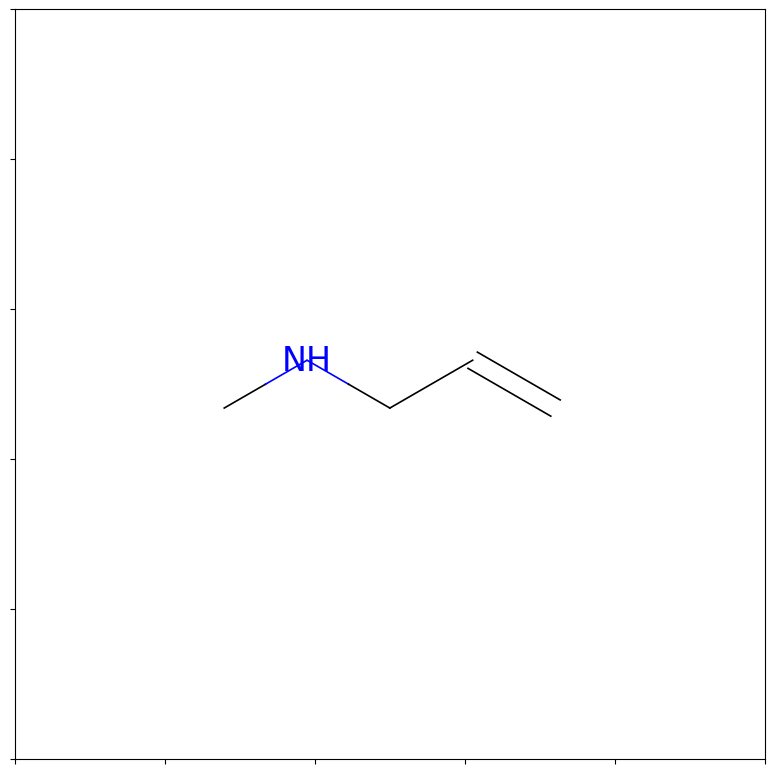

SMILES: C=CCNC, Molecular Formula: C4H9N, IUPAC Name: N-methylprop-2-en-1-amine


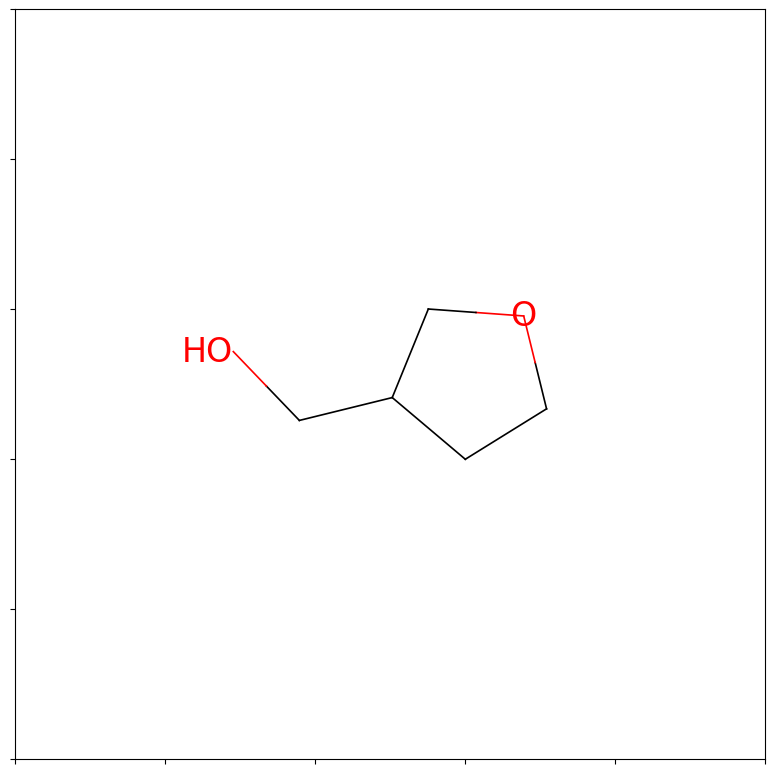

SMILES: OCC1CCOC1, Molecular Formula: C5H10O2, IUPAC Name: oxolan-3-ylmethanol


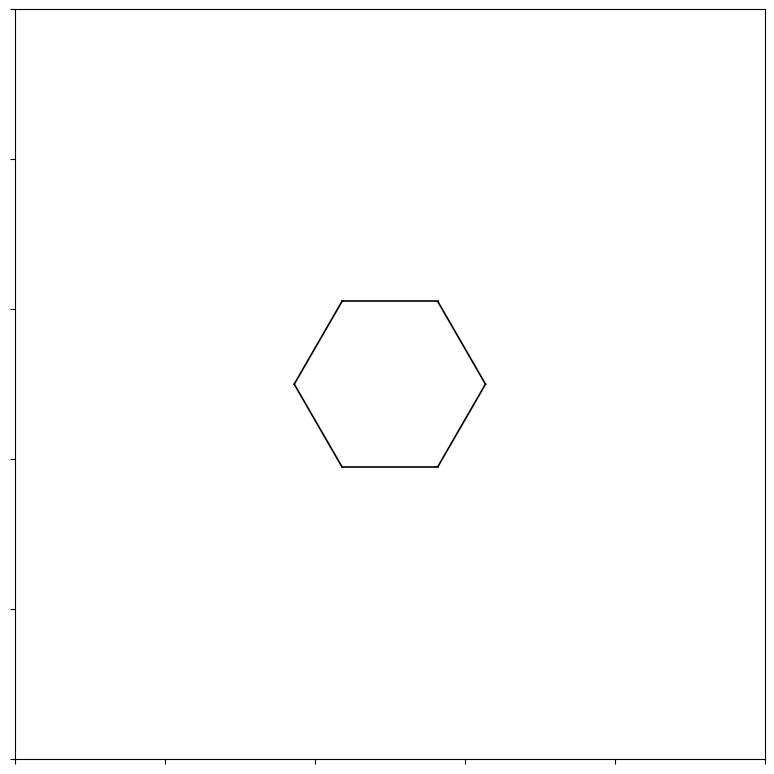

SMILES: C1CCCCC1, Molecular Formula: C6H12, IUPAC Name: cyclohexane


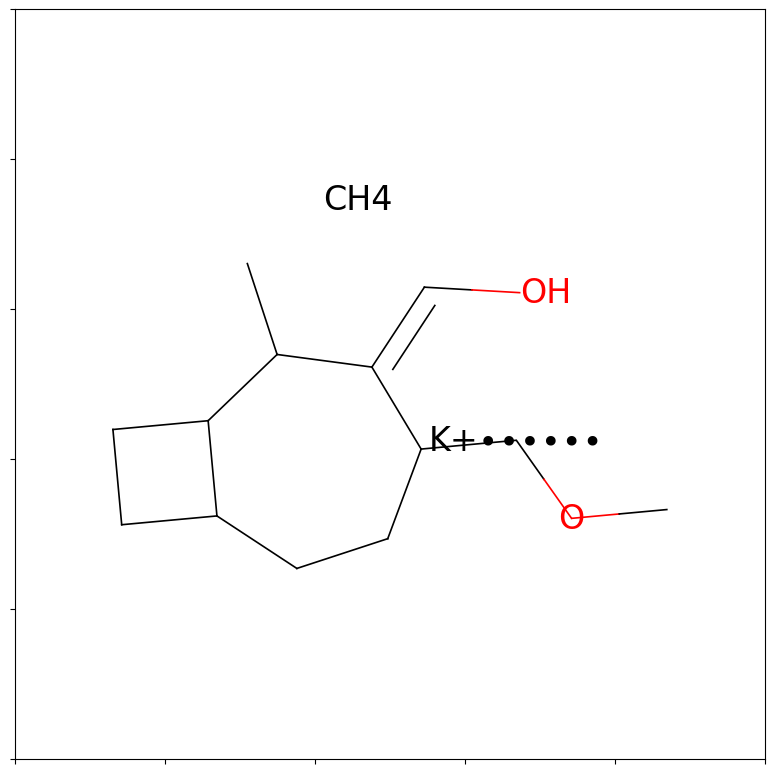

SMILES: C.CO[K+]C1CCC2CCC2C(C)C1=CO, Molecular Formula: C13H24KO2+, IUPAC Name: IUPAC name not found


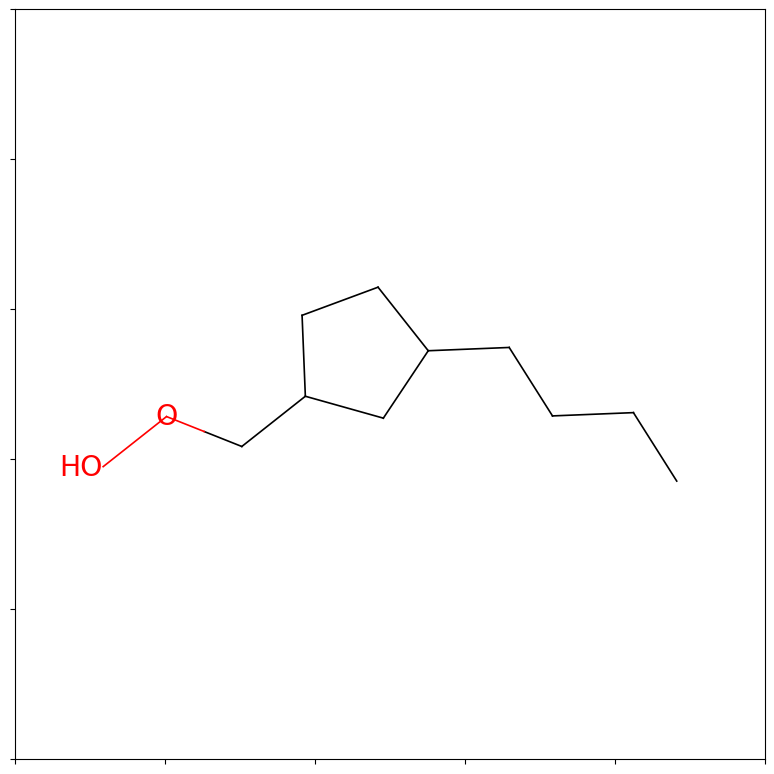

SMILES: CCCCC1CCC(COO)C1, Molecular Formula: C10H20O2, IUPAC Name: IUPAC name not found


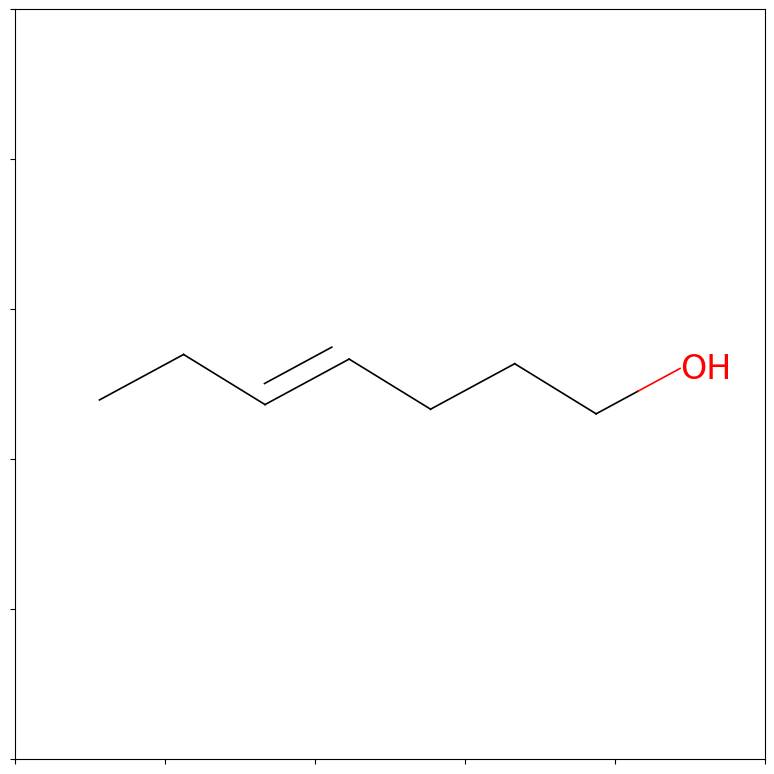

SMILES: CCC=CCCCO, Molecular Formula: C7H14O, IUPAC Name: hept-4-en-1-ol


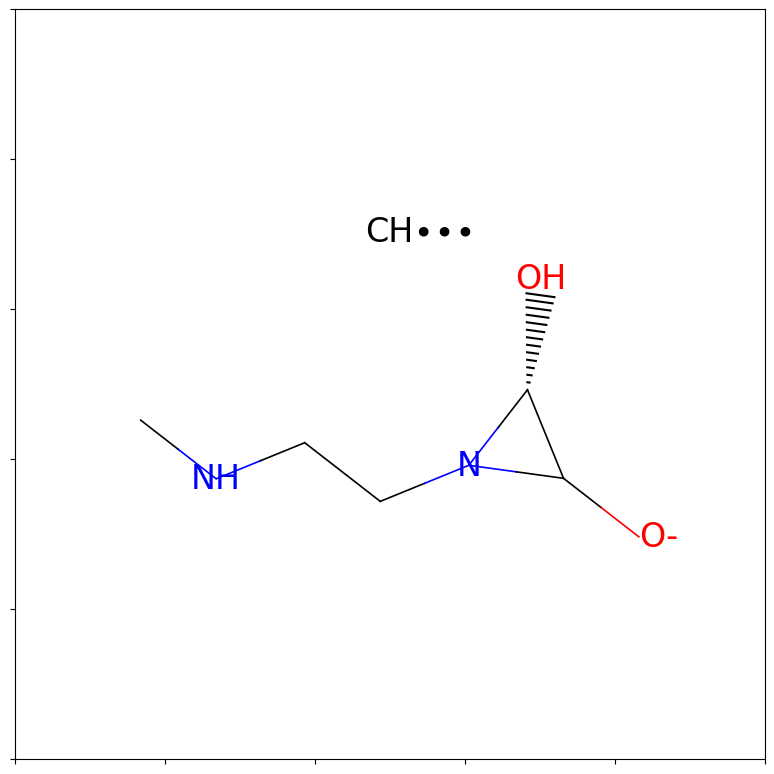

SMILES: CNCCN1C([O-])[C@H]1O.[CH], Molecular Formula: C6H12N2O2-, IUPAC Name: IUPAC name not found


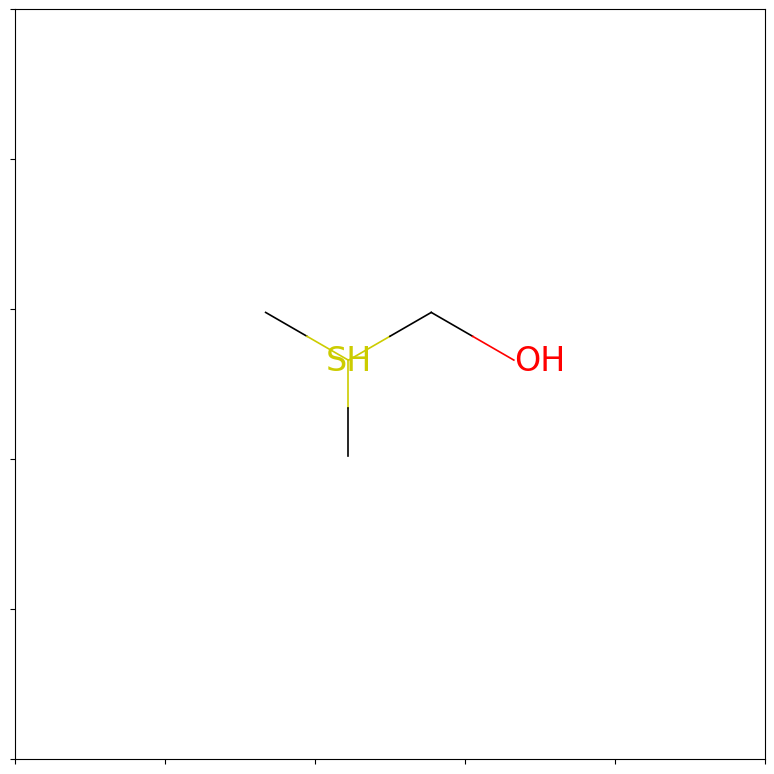

SMILES: C[SH](C)CO, Molecular Formula: C3H10OS, IUPAC Name: IUPAC name not found


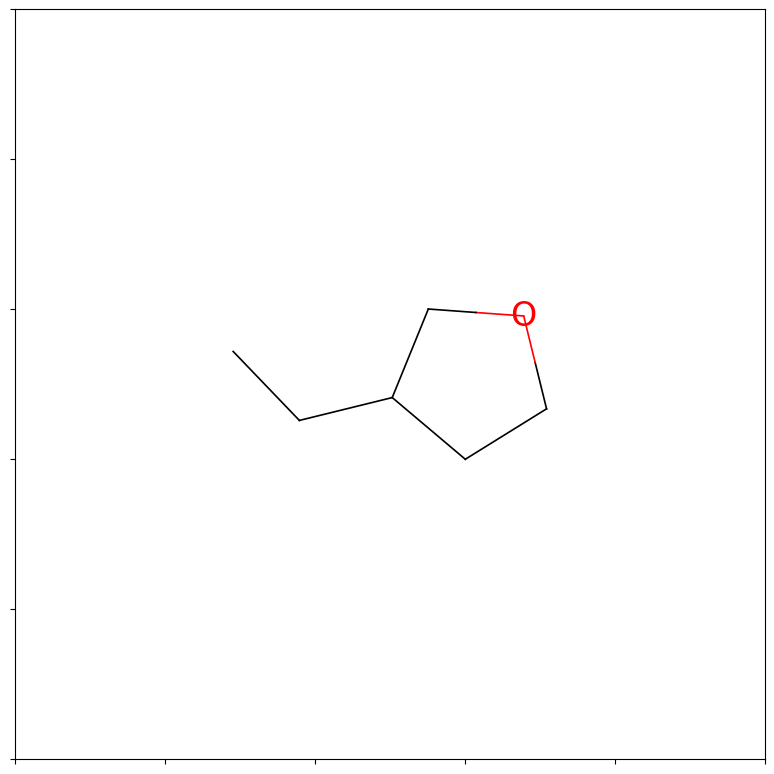

SMILES: CCC1CCOC1, Molecular Formula: C6H12O, IUPAC Name: 3-ethyloxolane


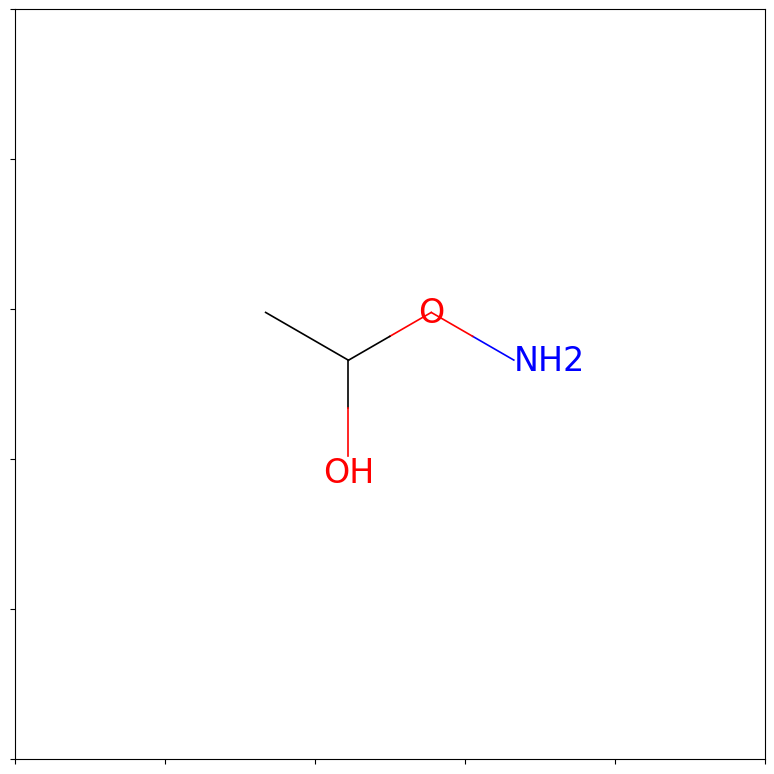

SMILES: CC(O)ON, Molecular Formula: C2H7NO2, IUPAC Name: 1-aminooxyethanol


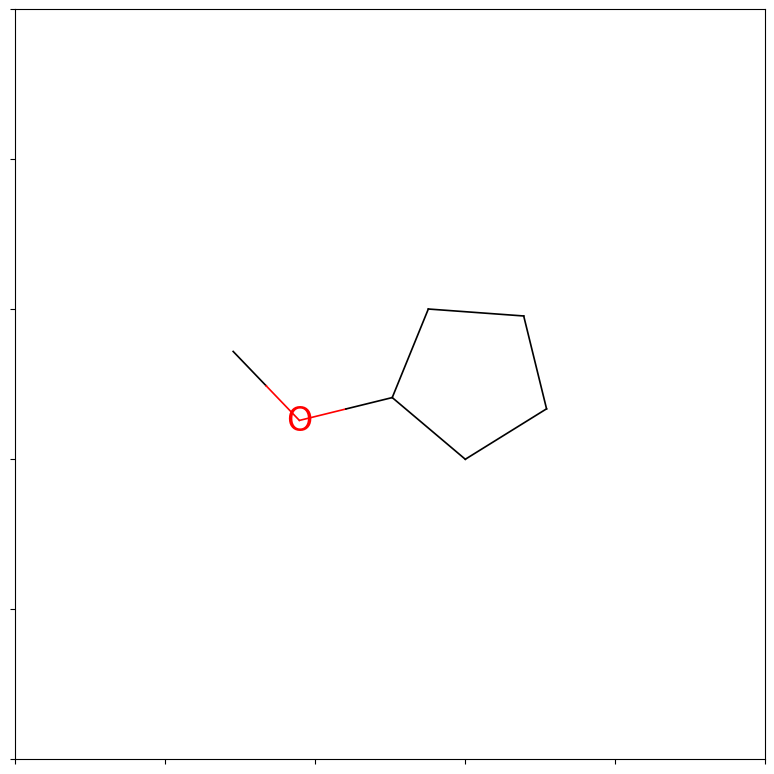

SMILES: COC1CCCC1, Molecular Formula: C6H12O, IUPAC Name: methoxycyclopentane


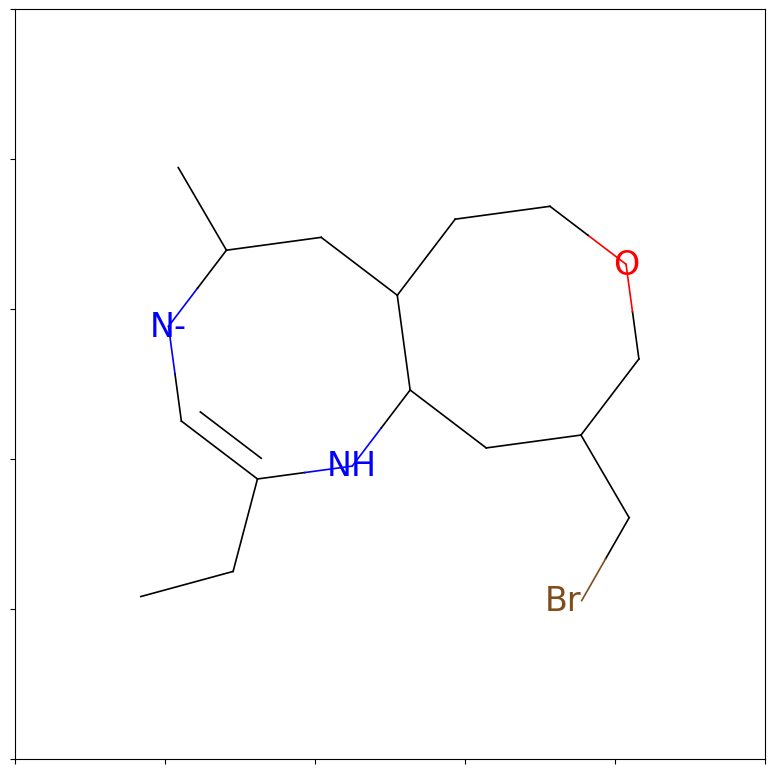

SMILES: CCC1=C[N-]C(C)CC2CCOCC(CBr)CC2N1, Molecular Formula: C15H26BrN2O-, IUPAC Name: IUPAC name not found


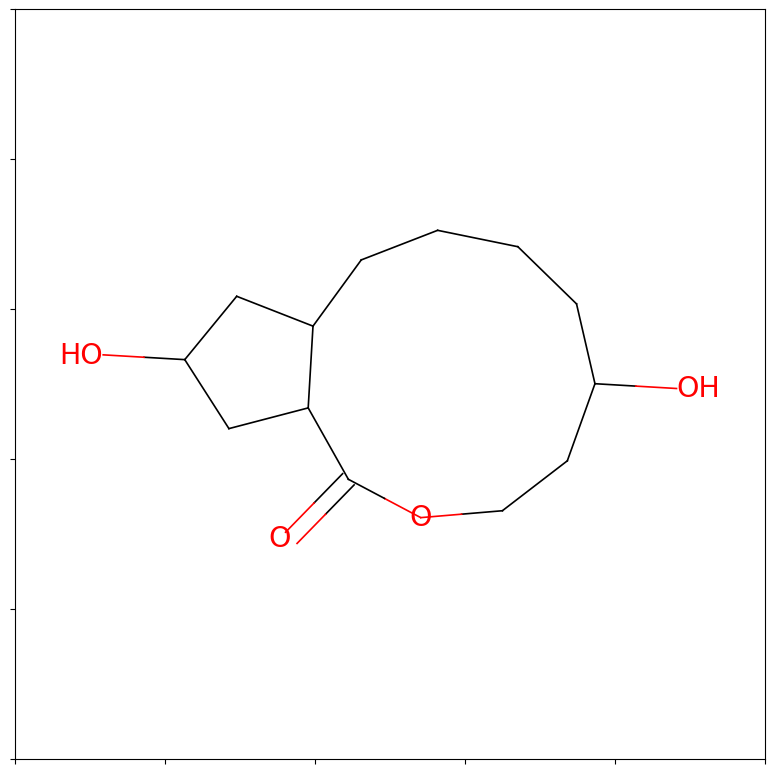

SMILES: O=C1OCCC(O)CCCCC2CC(O)CC12, Molecular Formula: C13H22O4, IUPAC Name: IUPAC name not found


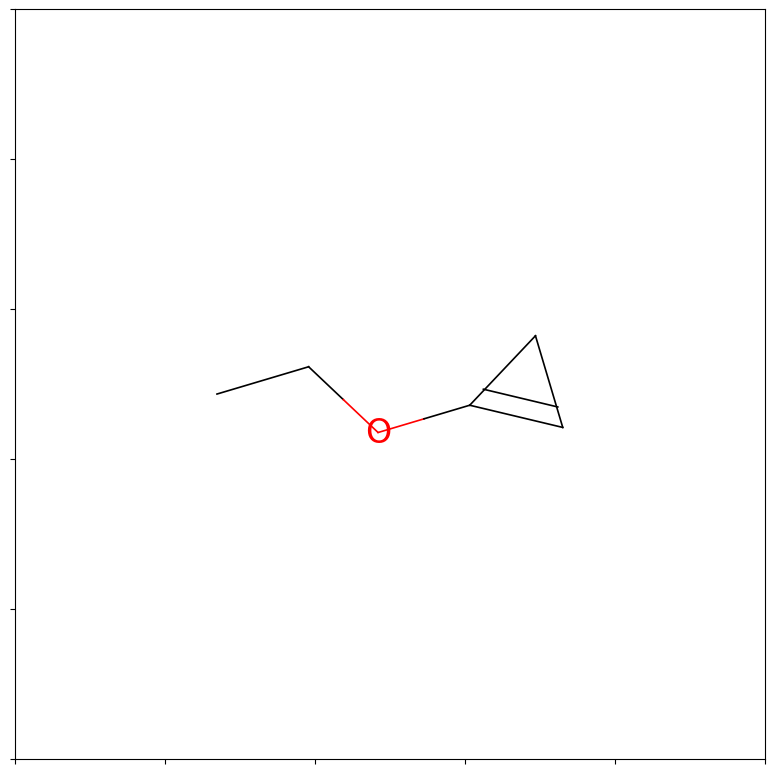

SMILES: CCOC1=CC1, Molecular Formula: C5H8O, IUPAC Name: 1-ethoxycyclopropene


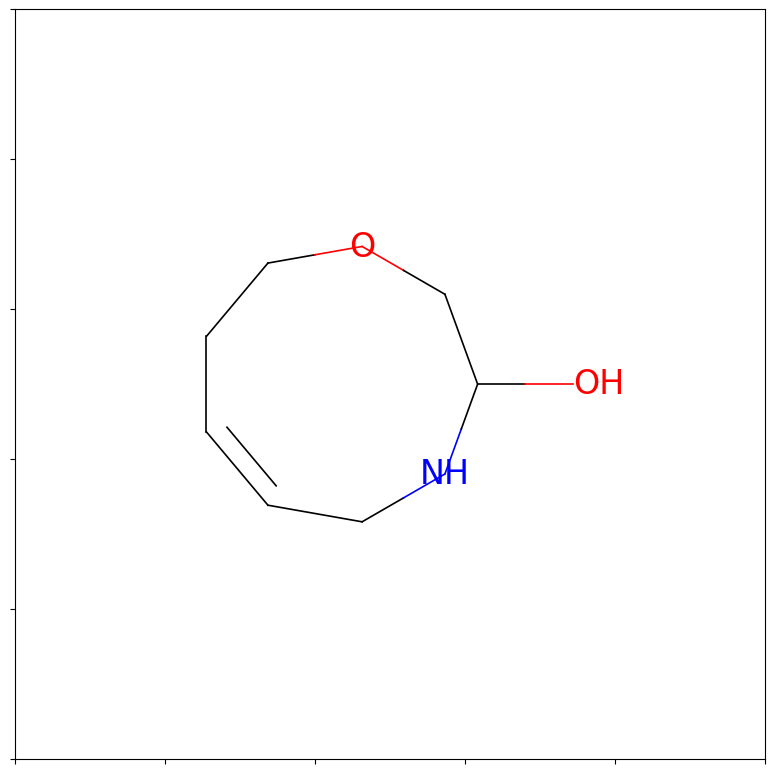

SMILES: OC1COCCC=CCN1, Molecular Formula: C7H13NO2, IUPAC Name: IUPAC name not found


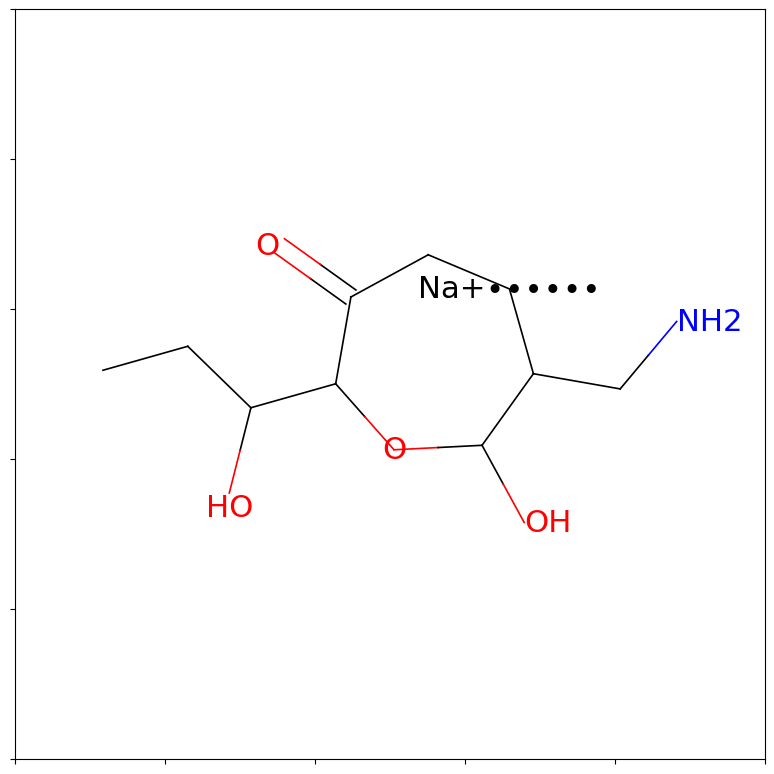

SMILES: CCC(O)C1OC(O)C(CN)[Na+]CC1=O, Molecular Formula: C9H17NNaO4+, IUPAC Name: IUPAC name not found


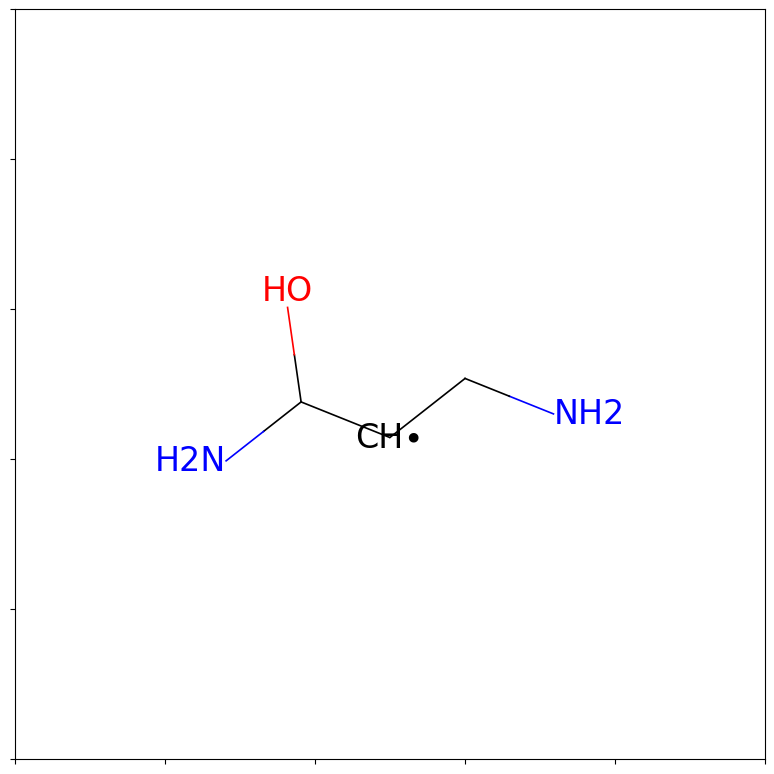

SMILES: NC[CH]C(N)O, Molecular Formula: C3H9N2O, IUPAC Name: 1,3-diaminopropan-1-ol


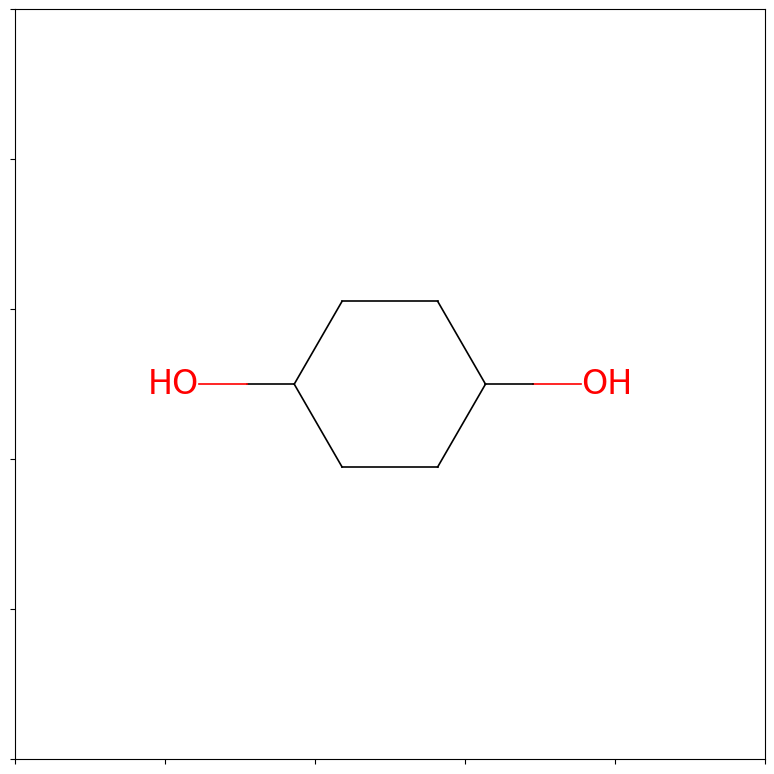

SMILES: OC1CCC(O)CC1, Molecular Formula: C6H12O2, IUPAC Name: cyclohexane-1,4-diol


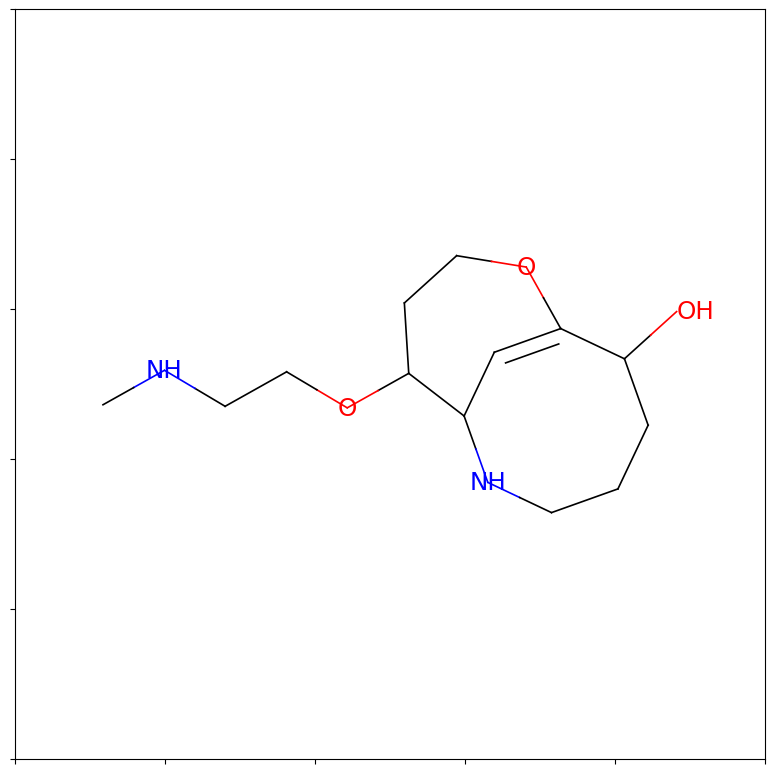

SMILES: CNCCOC1CCOC2=CC1NCCCC2O, Molecular Formula: C13H24N2O3, IUPAC Name: IUPAC name not found


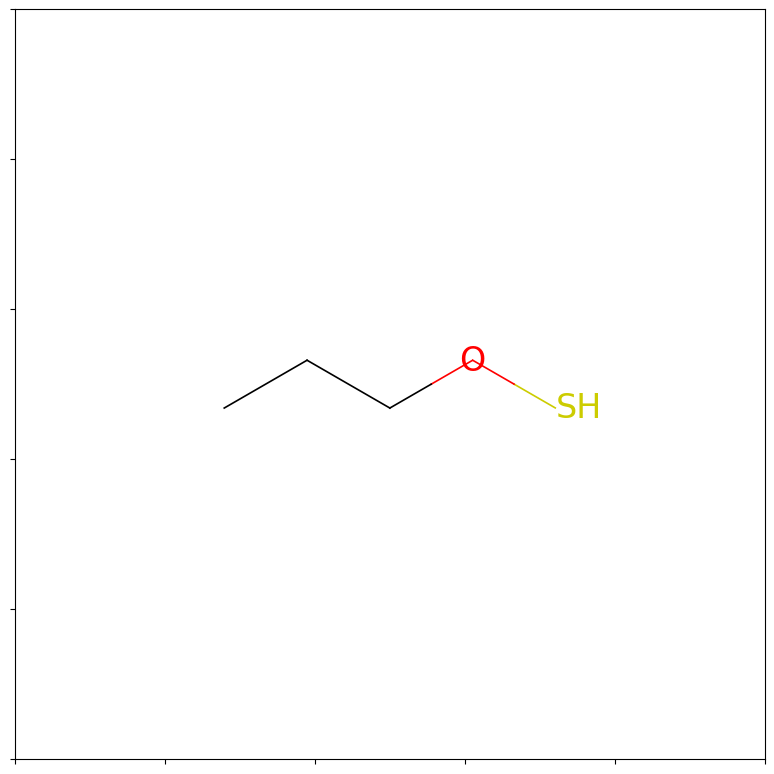

SMILES: CCCOS, Molecular Formula: C3H8OS, IUPAC Name: 1-sulfanyloxypropane


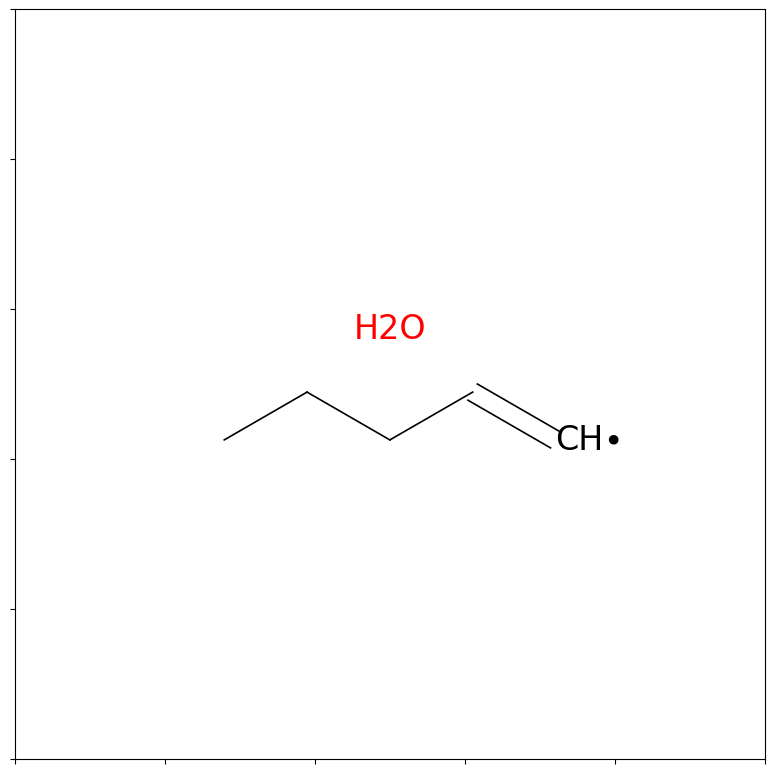

SMILES: O.[CH]=CCCC, Molecular Formula: C5H11O, IUPAC Name: pent-1-ene;hydrate


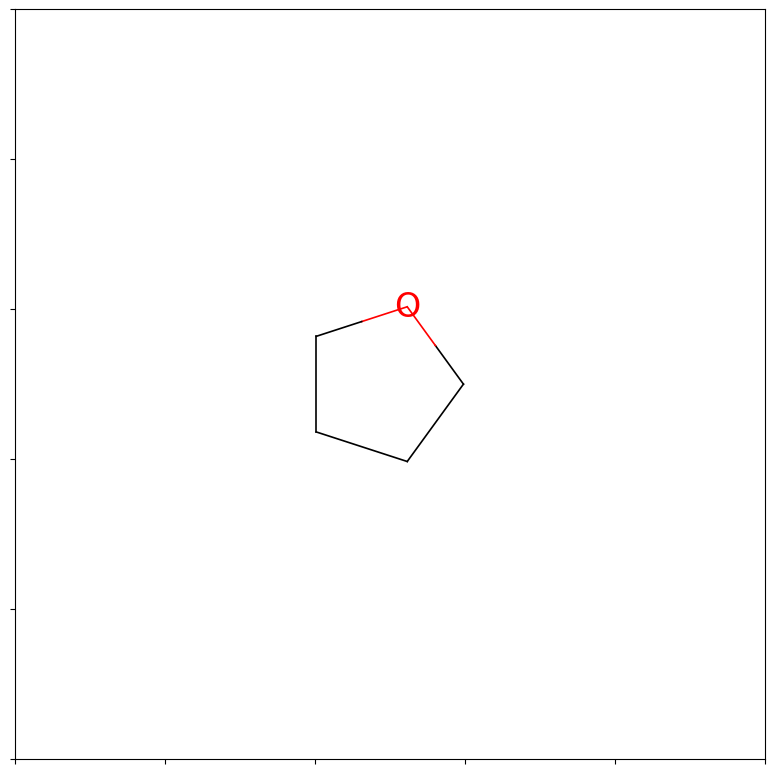

SMILES: C1CCOC1, Molecular Formula: C4H8O, IUPAC Name: oxolane


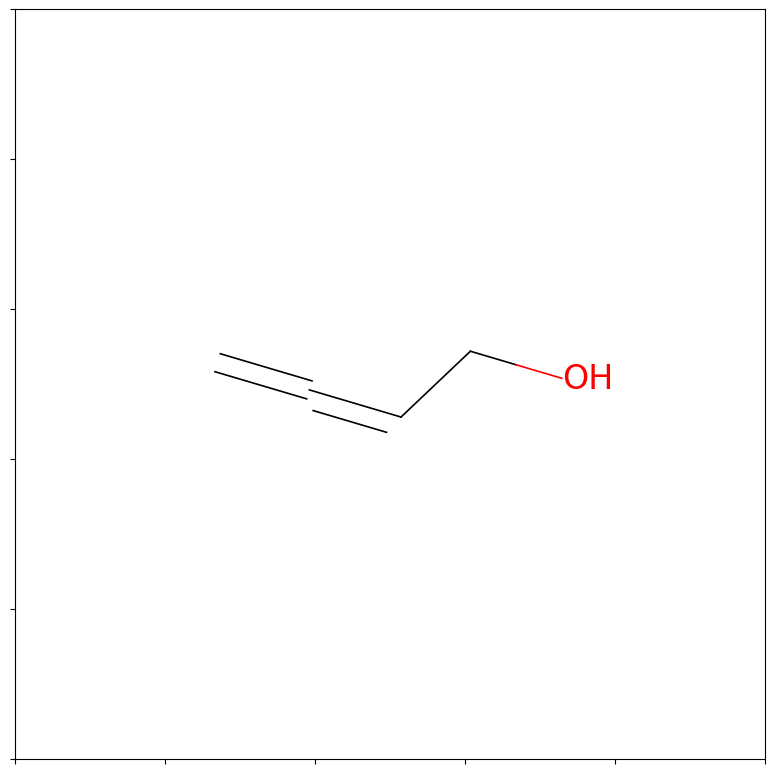

SMILES: C=C=CCO, Molecular Formula: C4H6O, IUPAC Name: IUPAC name not found


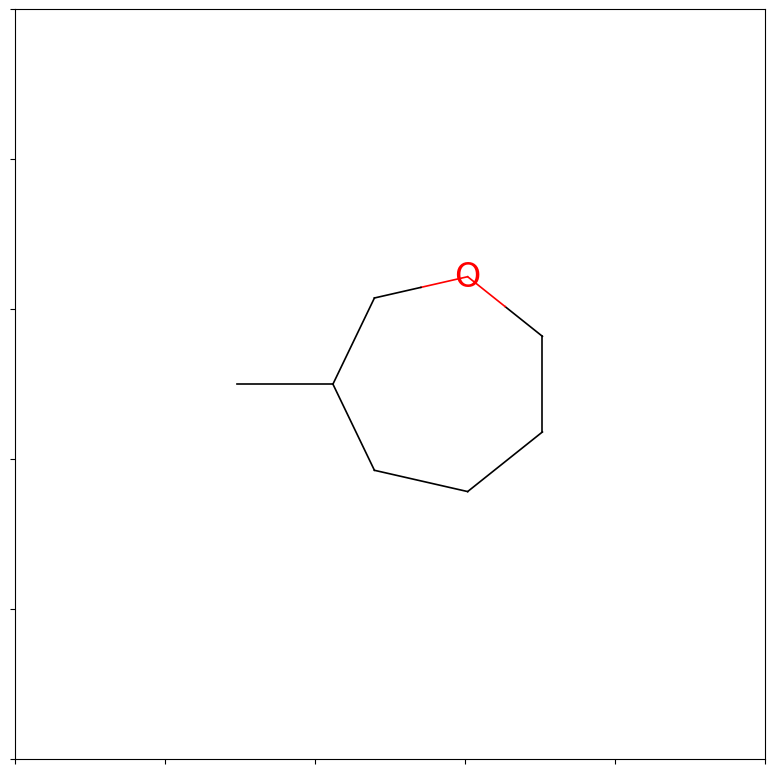

SMILES: CC1CCCCOC1, Molecular Formula: C7H14O, IUPAC Name: 3-methyloxepane


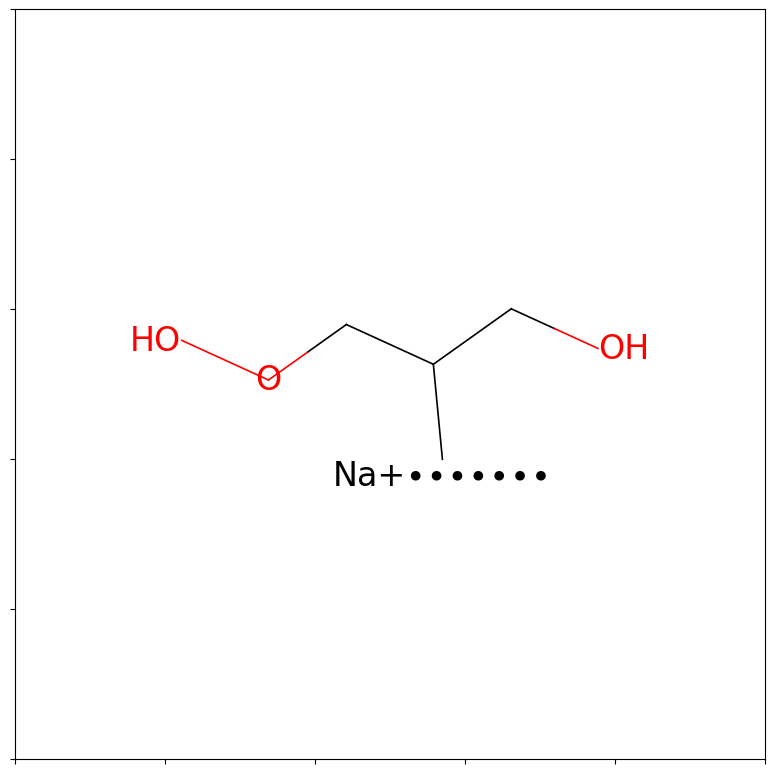

SMILES: OCC([Na+])COO, Molecular Formula: C3H7NaO3+, IUPAC Name: IUPAC name not found


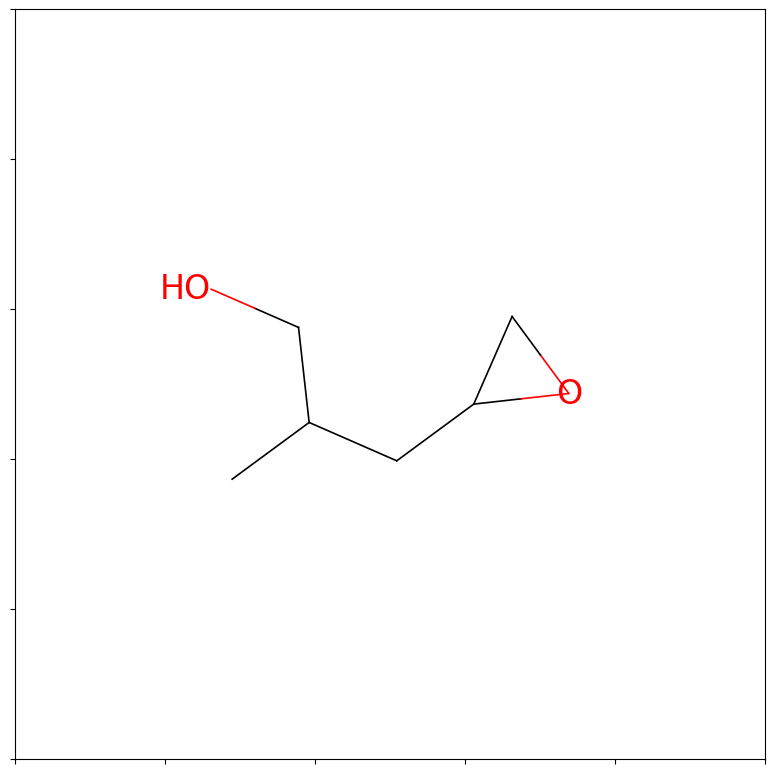

SMILES: CC(CO)CC1CO1, Molecular Formula: C6H12O2, IUPAC Name: 2-methyl-3-(oxiran-2-yl)propan-1-ol


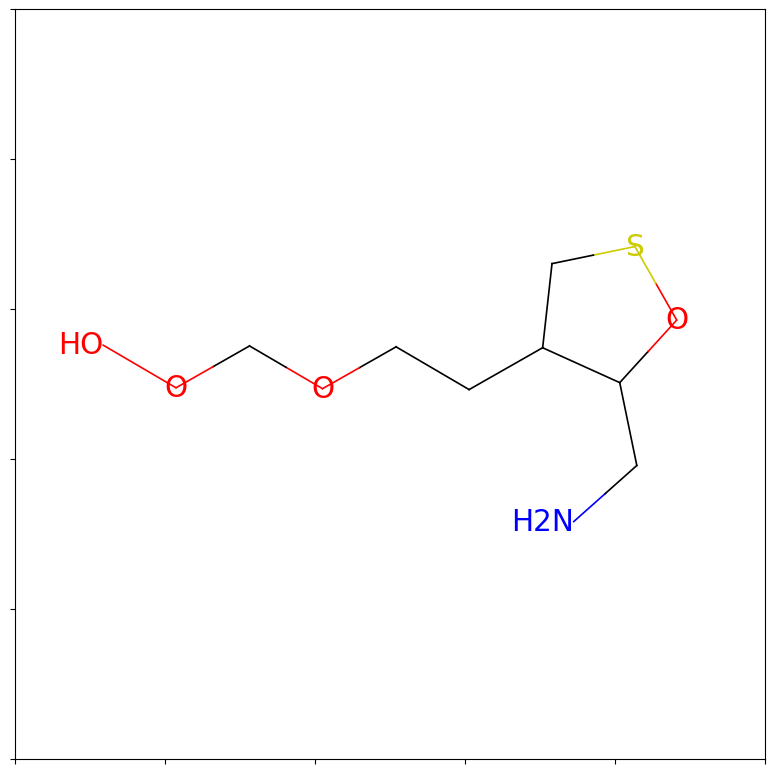

SMILES: NCC1OSCC1CCOCOO, Molecular Formula: C7H15NO4S, IUPAC Name: IUPAC name not found


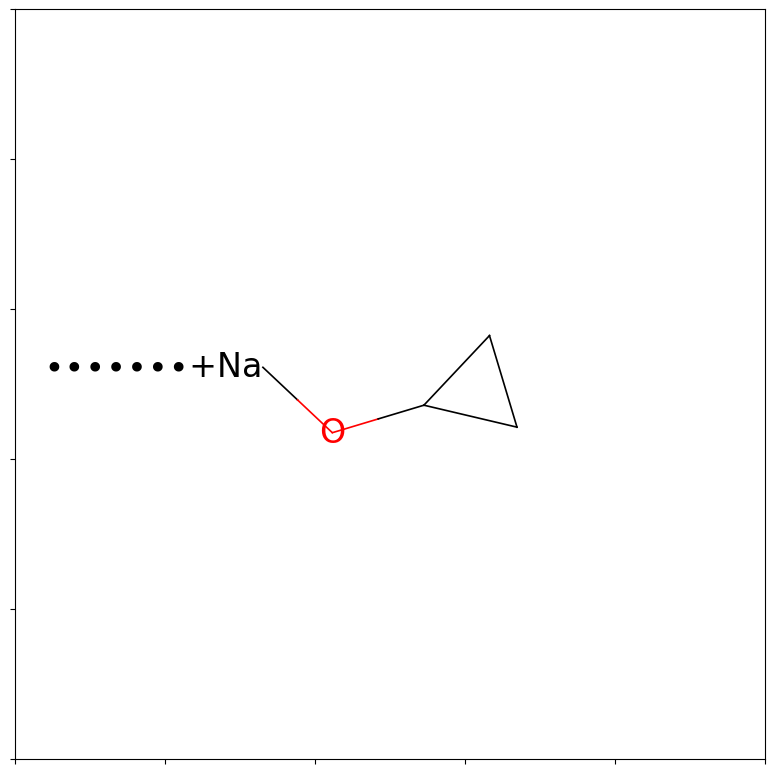

SMILES: [Na+]OC1CC1, Molecular Formula: C3H5NaO+, IUPAC Name: sodium;cyclopropanolate


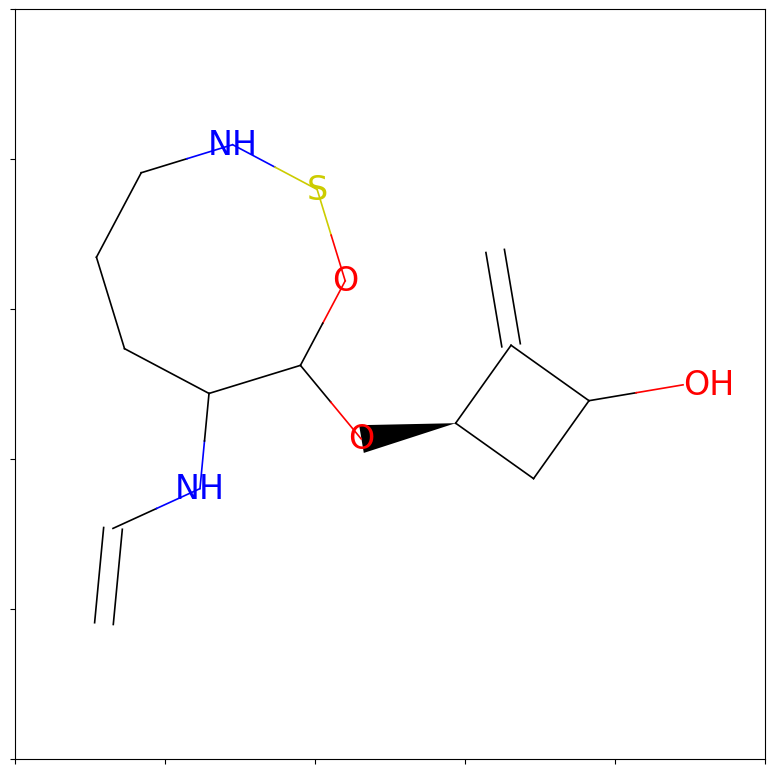

SMILES: C=CNC1CCCNSOC1O[C@@H]1CC(O)C1=C, Molecular Formula: C12H20N2O3S, IUPAC Name: IUPAC name not found


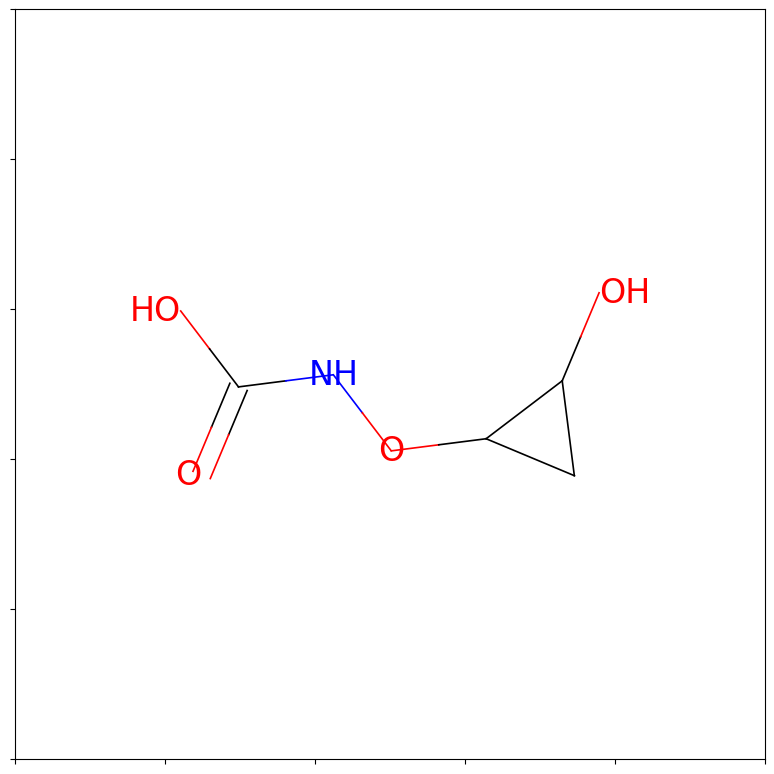

SMILES: O=C(O)NOC1CC1O, Molecular Formula: C4H7NO4, IUPAC Name: IUPAC name not found


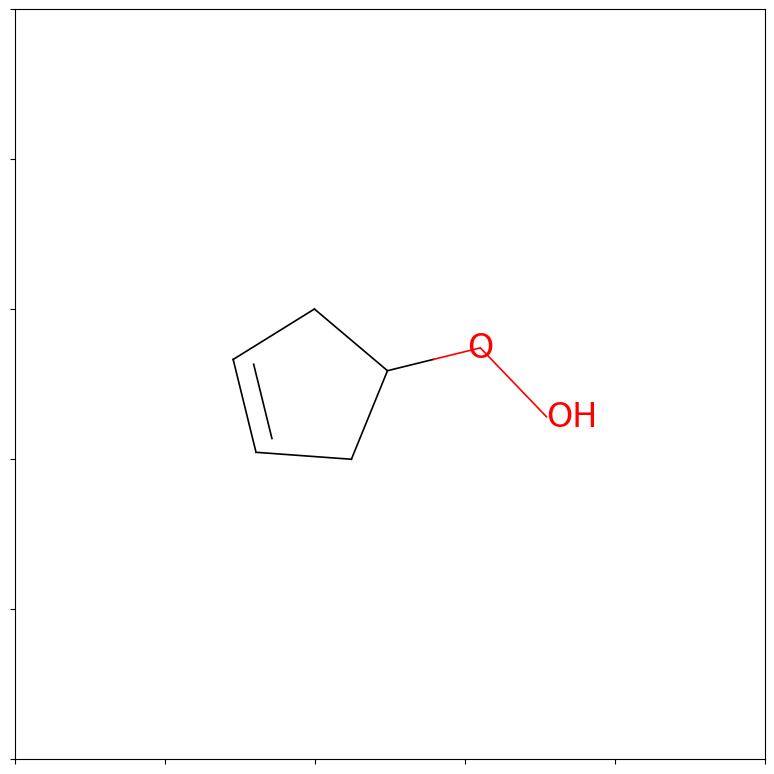

SMILES: OOC1CC=CC1, Molecular Formula: C5H8O2, IUPAC Name: 4-hydroperoxycyclopentene


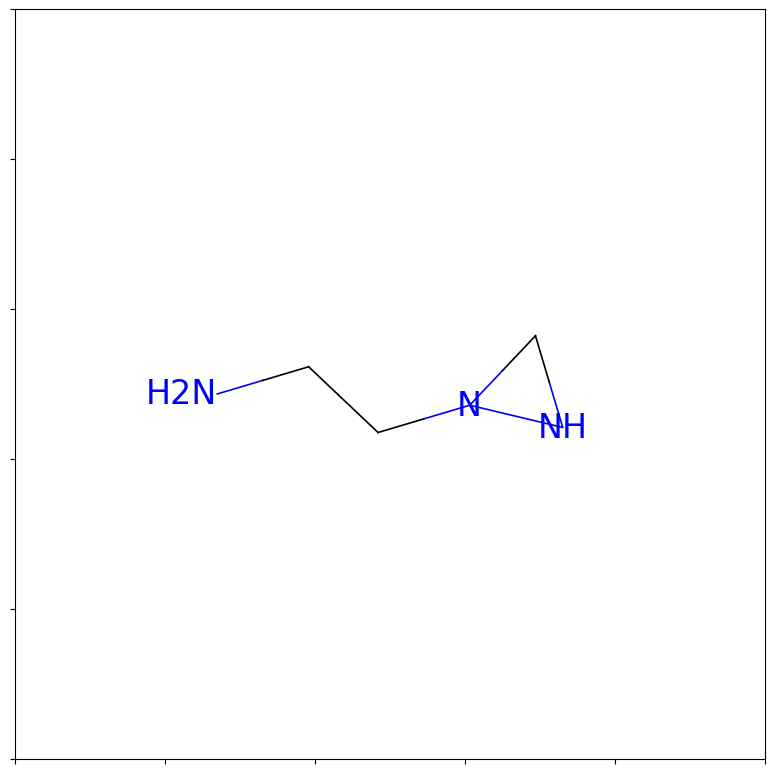

SMILES: NCCN1CN1, Molecular Formula: C3H9N3, IUPAC Name: 2-(diaziridin-1-yl)ethanamine


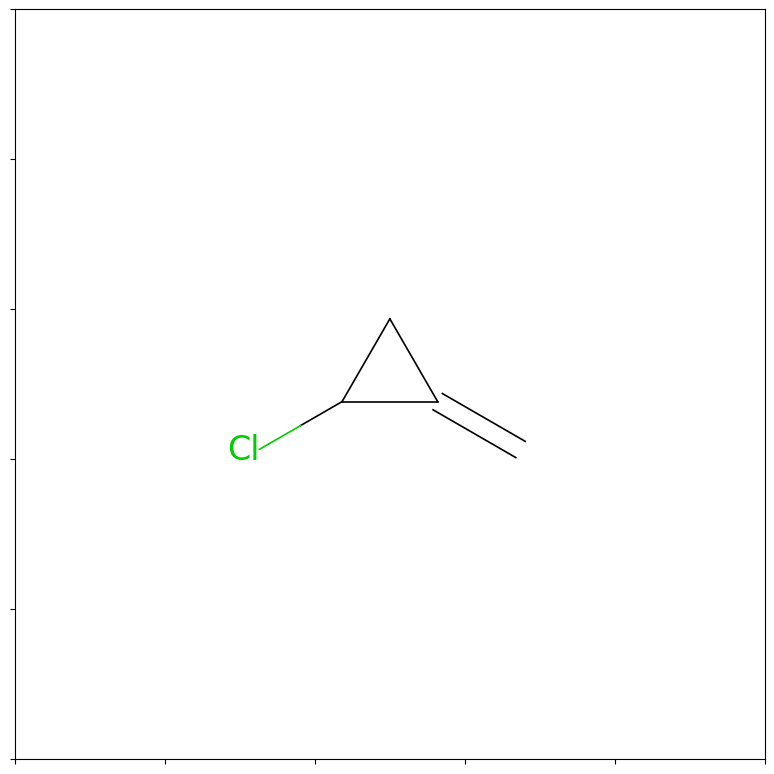

SMILES: C=C1CC1Cl, Molecular Formula: C4H5Cl, IUPAC Name: 1-chloro-2-methylidenecyclopropane


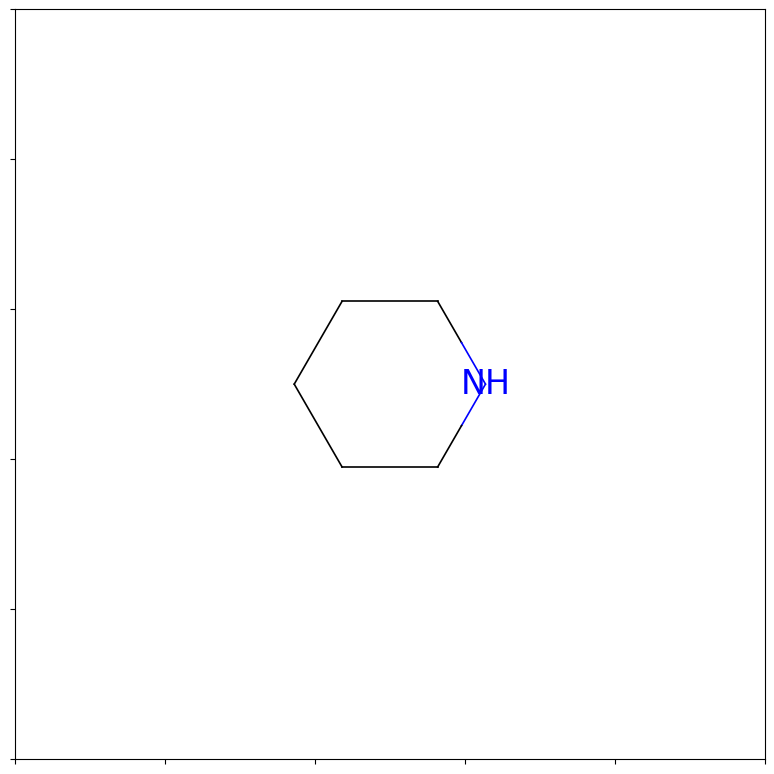

SMILES: C1CCNCC1, Molecular Formula: C5H11N, IUPAC Name: piperidine


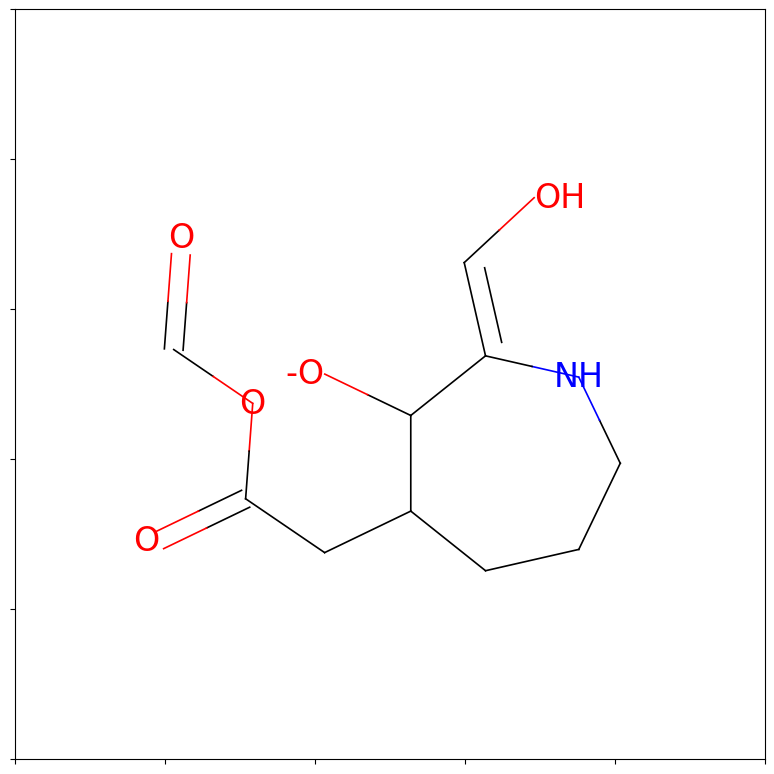

SMILES: O=COC(=O)CC1CCCNC(=CO)C1[O-], Molecular Formula: C10H14NO5-, IUPAC Name: IUPAC name not found


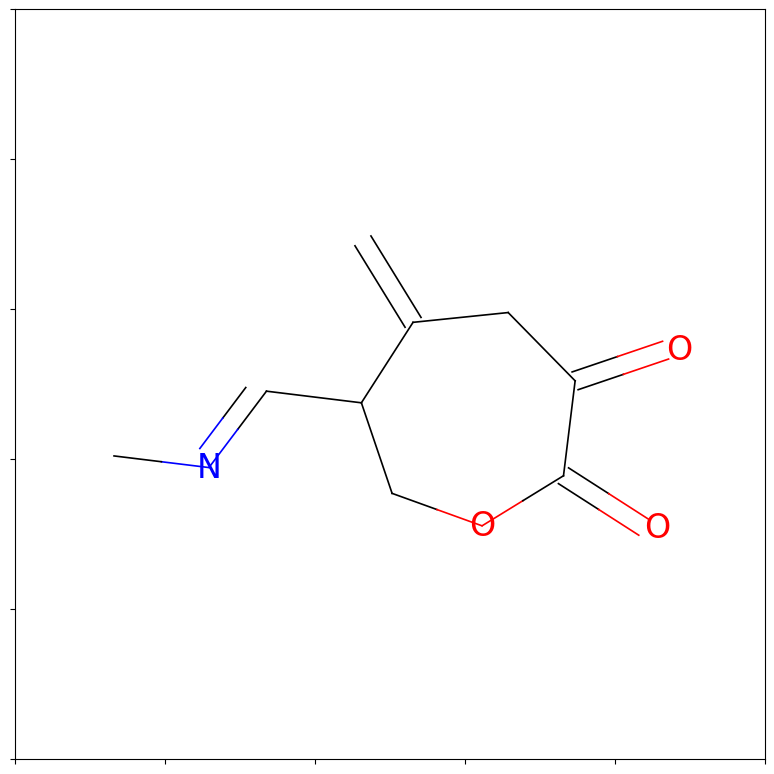

SMILES: C=C1CC(=O)C(=O)OCC1C=NC, Molecular Formula: C9H11NO3, IUPAC Name: IUPAC name not found


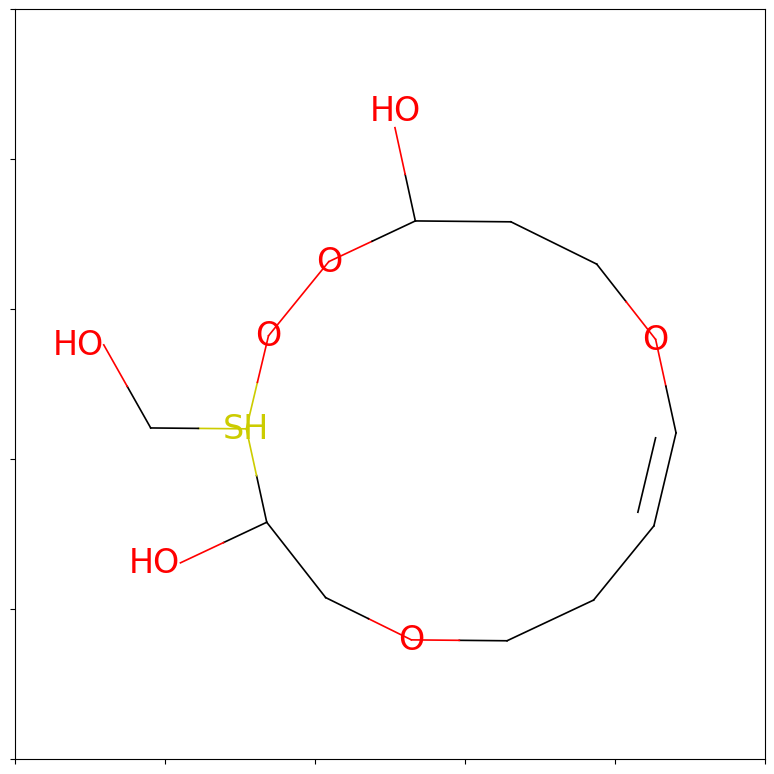

SMILES: OC[SH]1OOC(O)CCOC=CCCOCC1O, Molecular Formula: C10H20O7S, IUPAC Name: IUPAC name not found


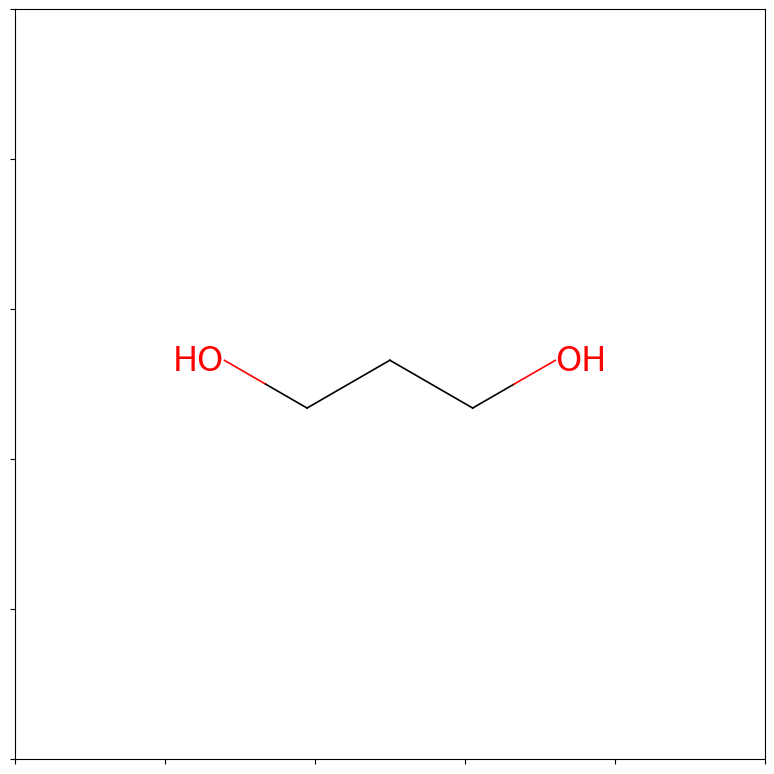

SMILES: OCCCO, Molecular Formula: C3H8O2, IUPAC Name: propane-1,3-diol


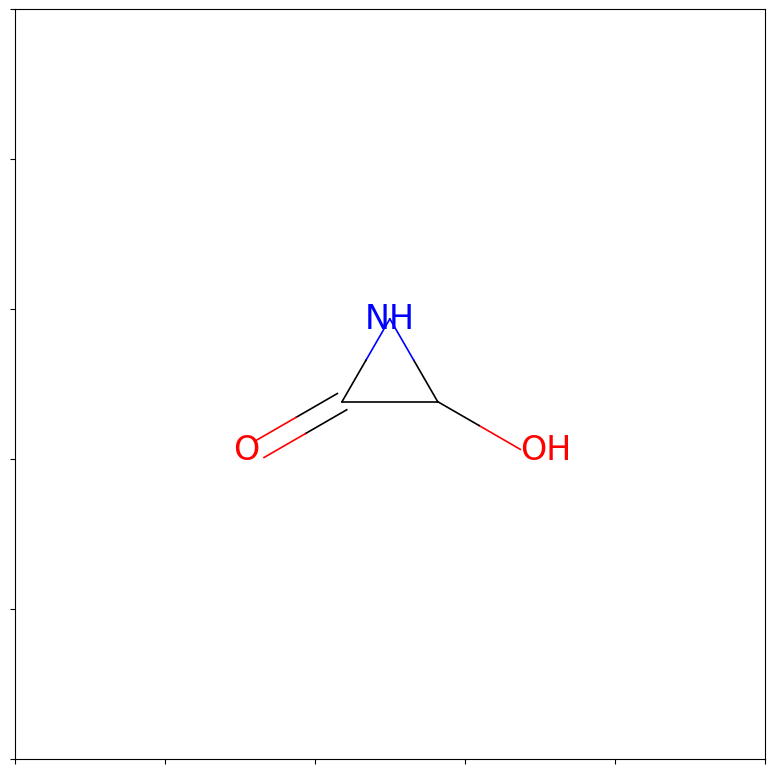

SMILES: O=C1NC1O, Molecular Formula: C2H3NO2, IUPAC Name: 3-hydroxyaziridin-2-one


In [ ]:


# Function to get molecular formula
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import requests

# Function to get molecular formula
def get_molecular_formula(mol):
    return Chem.rdMolDescriptors.CalcMolFormula(mol)

# Function to get IUPAC name using PubChem API
def get_iupac_name(smiles):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/property/IUPACName/JSON"
    response = requests.get(url)
    if response.status_code == 200:
        try:
            data = response.json()
            return data['PropertyTable']['Properties'][0]['IUPACName']
        except (KeyError, IndexError):
            return "IUPAC name not found"
    return "IUPAC name not found"


for mol in gen:
    if mol:
        # Draw the molecule
        Chem.Draw.MolToMPL(mol)
        plt.show()
        plt.close()

        # Calculate the molecular formula
        formula = get_molecular_formula(mol)

        # Get SMILES string from RDKit molecule
        smiles = Chem.MolToSmiles(mol)

        # Get IUPAC name using PubChem API
        iupac_name = get_iupac_name(smiles)

        print(f"SMILES: {smiles}, Molecular Formula: {formula}, IUPAC Name: {iupac_name}")
    else:
        print("Invalid molecule")



Download the Output as HTML file


In [ ]:
!pip install rdkit-pypi

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
import io
from PIL import Image
import base64
import requests

# Example RDKit molecule objects (you can replace these with your own RDKit molecules)
molecules = gen

def get_molecular_formula(mol):
    return Chem.rdMolDescriptors.CalcMolFormula(mol)

def get_iupac_name(smiles):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/property/IUPACName/JSON"
    response = requests.get(url)
    if response.status_code == 200:
        try:
            data = response.json()
            return data['PropertyTable']['Properties'][0]['IUPACName']
        except (KeyError, IndexError):
            return "IUPAC name not found"
    return "IUPAC name not found"

def molecule_to_smiles(molecule):
    if molecule:
        try:
            smiles = Chem.MolToSmiles(molecule)
            return smiles
        except:
            return "SMILES conversion error"
    else:
        return "Invalid molecule"

def smiles_to_image(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        img = Draw.MolToImage(mol)
        return img
    else:
        return None

data = []

for molecule in molecules:
    if molecule:
        smiles = molecule_to_smiles(molecule)
        formula = get_molecular_formula(molecule)
        iupac_name = get_iupac_name(smiles)
        img = smiles_to_image(smiles)

        if img:
            buffer = io.BytesIO()
            img.save(buffer, format="PNG")
            img_str = buffer.getvalue()
        else:
            img_str = None

        data.append({
            "SMILES": smiles,
            "Molecular Formula": formula,
            "IUPAC Name": iupac_name,
            "Image": img_str
        })

df = pd.DataFrame(data)

def save_to_html(df, output_file):
    with open(output_file, 'w') as f:
        f.write('<html><body>\n')
        f.write('<table border="1">\n')
        f.write('<tr><th>SMILES</th><th>Molecular Formula</th><th>IUPAC Name</th><th>Image</th></tr>\n')

        for _, row in df.iterrows():
            f.write('<tr>\n')
            f.write(f'<td>{row["SMILES"]}</td>\n')
            f.write(f'<td>{row["Molecular Formula"]}</td>\n')
            f.write(f'<td>{row["IUPAC Name"]}</td>\n')

            if row["Image"]:
                img_str = row["Image"]
                img_base64 = base64.b64encode(img_str).decode('utf-8')
                img_tag = f'<img src="data:image/png;base64,{img_base64}" />'
                f.write(f'<td>{img_tag}</td>\n')
            else:
                f.write('<td>Image generation error</td>\n')

            f.write('</tr>\n')

        f.write('</table>\n')
        f.write('</body></html>\n')

save_to_html(df, 'output.html')

from google.colab import files
files.download('output.html')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>